In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from datetime import datetime
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pylab import rcParams
import calendar

In [2]:
# Read data
df = pd.read_csv('train_1.csv/train_1.csv')
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [3]:
df = df.fillna(0)

In [4]:
df_reshaped = pd.melt(df,id_vars=['Page'],var_name='Date',value_name='Views')
df_reshaped.head()

,Page,Date,Views
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-01,35.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-01,0.0


In [5]:
df_reshaped['Date'] = pd.to_datetime(df_reshaped['Date']) 
df_reshaped = df_reshaped.set_index('Date')

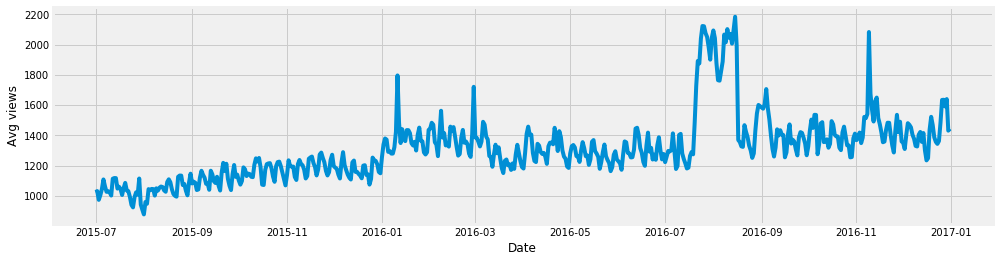

In [6]:
temp = df_reshaped.groupby('Date')['Views'].mean()
plt.figure(figsize=(15,4))
plt.xlabel('Date')
plt.ylabel('Avg views')
plt.plot(temp)

In [ ]:
month_index = df_reshaped.index.month
views_by_month = df_reshaped.groupby(month_index).mean()
months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_month.plot()
start, end = ax.get_xlim()
plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
ax.set_xticklabels(months,rotation=75)
ax.set_xlabel('Month')
ax.set_ylabel('Average views')
plt.show()

In [ ]:
weekday_index = df_reshaped.index.weekday_name
views_by_weekdays = df_reshaped.groupby(weekday_index).sum()
#months=['January','Feb','March','April','May','June','July','August','September','October','November','December']

ax = views_by_weekdays.plot()
#start, end = ax.get_xlim()
#plt.xticks(np.arange(start+0.5, end+0.5, 1.0))
#ax.set_xticklabels(months,rotation=75)
#ax.set_xlabel('Month')
ax.set_ylabel('Total views')
plt.show()

In [ ]:
def detect_lang(page):
    text = page.split('.wikipedia')
    if re.search('[a-z][a-z]',text[0][-2:]):
        return text[0][-2:]
    else: 
        return 'none'
    
df_reshaped['Page_language'] = df_reshaped.Page.apply(detect_lang)

def lang_code(code):
    if code == 'zh':
        return 'Chinese'
    elif code == 'fr':
        return 'French'
    elif code == 'en':
        return 'English'
    elif code == 'ru':
        return 'Russian'
    elif code == 'de':
        return 'German'
    elif code == 'ja':
        return 'Japanese'
    elif code == 'es':
        return 'Spanish'
    else:
        return 'None'
    
df_reshaped['Page_language'] = df_reshaped.Page_language.apply(lang_code)

In [ ]:
fig,ax = plt.subplots(figsize=(15,6))
lang_df = df_reshaped.groupby('Page_language')['Views'].sum().reset_index()
lang_df = lang_df[lang_df['Page_language']!='None']
lang_df['Views'] = round(lang_df['Views']/1000000,0)

bar_graph = lang_df.plot.bar(x='Page_language',y='Views',rot=30,ax=ax)
bar_graph.set_ylabel('Total views (in millions)')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+500))
ax.legend()
plt.show()

In [ ]:
df_reshaped['Dayofweek'] = df_reshaped.Date.dt.dayofweek

def find_day(day):
    if day == 0:
        return 'Monday'
    elif day == 1:
        return 'Tuesday'
    elif day == 2:
        return 'Wednesday'
    elif day == 3:
        return 'Thursday'
    elif day == 4:
        return 'Friday'
    elif day == 5:
        return 'Saturday'
    else:
        return 'Sunday'
    
df_reshaped['Dayofweek'] = df_reshaped.Dayofweek.apply(find_day)

In [ ]:
day = df_reshaped.groupby('Dayofweek')['Views'].sum()
plt.figure(figsize=(15,4))
plt.xlabel('Day of week')
plt.ylabel('Total views')
plt.plot(day)
plt.show()

In [7]:
top_pages = df_reshaped.groupby('Page')['Views'].sum().reset_index()
top_pages.nlargest(5,'Views')

,Page,Views
58761,Main_Page_en.wikipedia.org_all-access_all-agents,1.206618e+10
58763,Main_Page_en.wikipedia.org_desktop_all-agents,8.774497e+09
58764,Main_Page_en.wikipedia.org_mobile-web_all-agents,3.153985e+09
93891,Wikipedia:Hauptseite_de.wikipedia.org_all-acce...,1.603934e+09
82337,Special:Search_en.wikipedia.org_all-access_all...,1.304079e+09


In [8]:
top5_pages_df = df_reshaped[df_reshaped['Page'].isin(['Main_Page_en.wikipedia.org_all-access_all-agents','Main_Page_en.wikipedia.org_desktop_all-agents','Main_Page_en.wikipedia.org_mobile-web_all-agents','Wikipedia:Hauptseite_de.wikipedia.org_all-access_all-agents','Special:Search_en.wikipedia.org_all-access_all-agents'])]

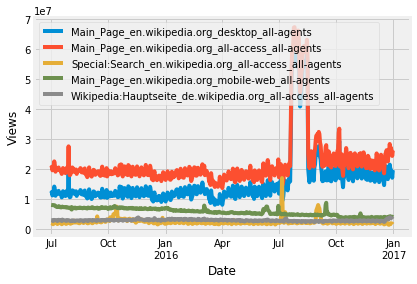

In [9]:
for i in list(top5_pages_df.Page.unique())[:5]:
    ax = top5_pages_df.loc[top5_pages_df.Page == i,:].Views.plot(label=i)
ax.set_ylabel('Views')
plt.legend(loc='upper left')
plt.show()

In [10]:
table = pd.pivot_table(top5_pages_df,values='Views',index=['Date'],columns=['Page'])

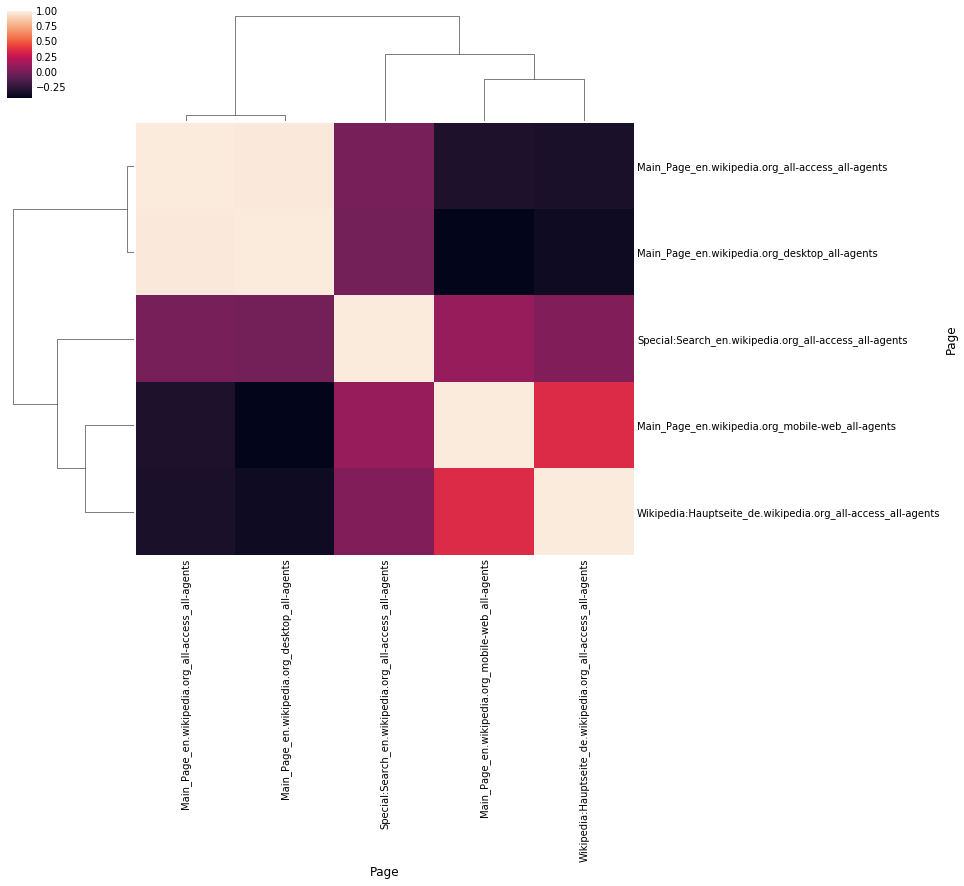

In [11]:
corr_matrix = table.corr(method='pearson')
sns.clustermap(corr_matrix)

In [12]:
top_page_df = df_reshaped[df_reshaped.Page == 'Main_Page_en.wikipedia.org_all-access_all-agents']
top_page_df.head()

,Page,Views
Date,,
2015-07-01,Main_Page_en.wikipedia.org_all-access_all-agents,20381245.0
2015-07-02,Main_Page_en.wikipedia.org_all-access_all-agents,20752194.0
2015-07-03,Main_Page_en.wikipedia.org_all-access_all-agents,19573967.0
2015-07-04,Main_Page_en.wikipedia.org_all-access_all-agents,20439645.0
2015-07-05,Main_Page_en.wikipedia.org_all-access_all-agents,20772109.0


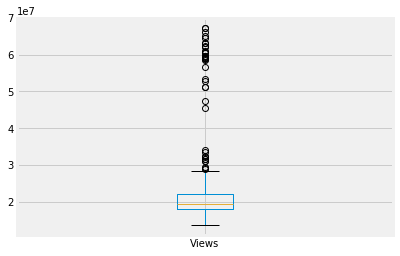

In [13]:
ax1 = top_page_df.boxplot()

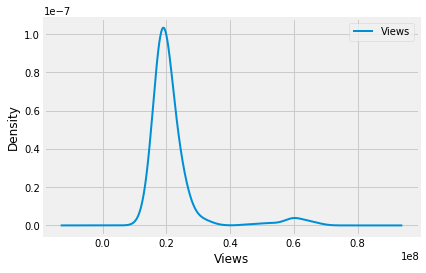

In [14]:
ax2 = top_page_df.plot(kind='density', linewidth=2)
ax2.set_xlabel('Views')
plt.show()

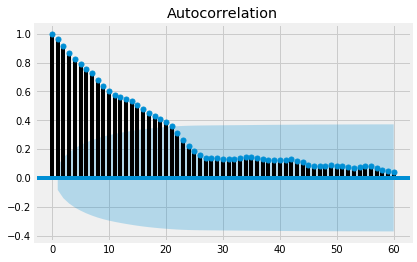

In [15]:
fig = tsaplots.plot_acf(top_page_df['Views'], lags=60)
plt.show()

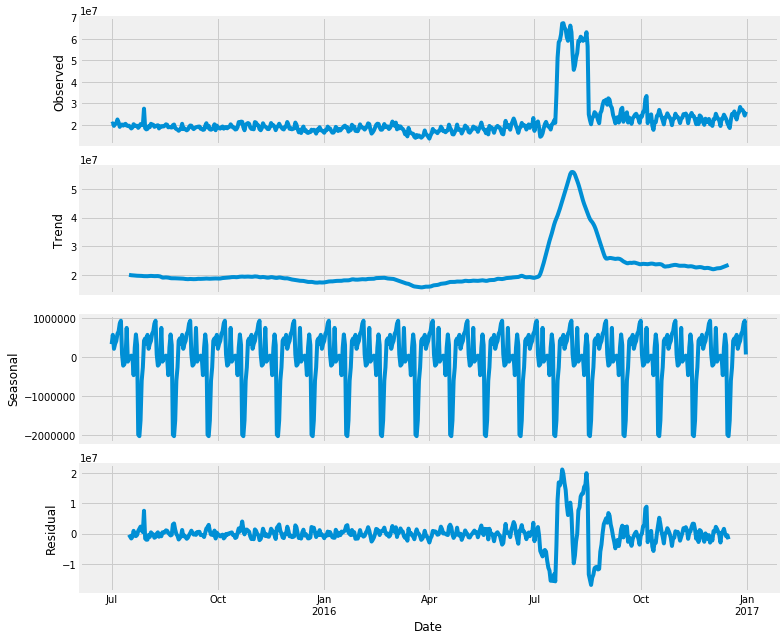

In [16]:
rcParams['figure.figsize'] = 11,9
ts_decomposition = sm.tsa.seasonal_decompose(top_page_df['Views'],freq = 30)
figure = ts_decomposition.plot()
plt.show()

## Augmented Dicky-Fuller test

In [17]:
test = adfuller(top_page_df['Views'])
print(test)

(-2.9901447422616267, 0.03582506369610538, 15, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17078.891523280352)


 0th element is the test statistic. Since the value is approximately -3, we can say that the data is more likely to be stationary.
 1st element indicates the p-value. Since the p-value is < 0.05, we can reject null hypothesis.

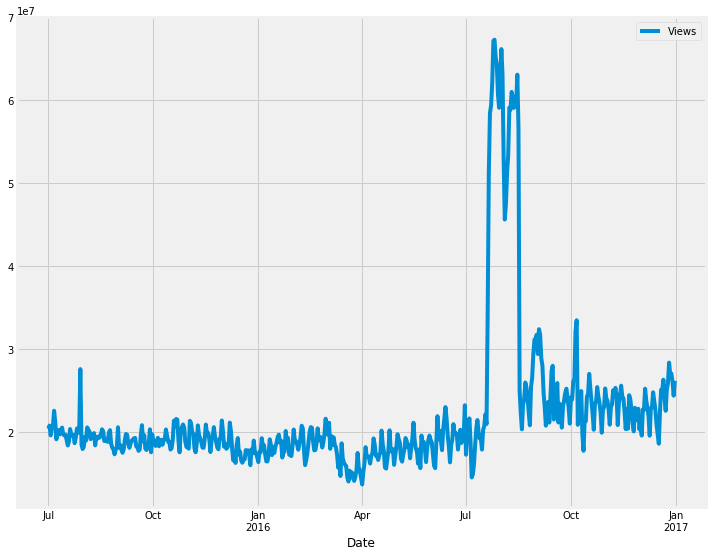

In [18]:
ax = top_page_df.plot()
plt.show()

In [19]:
top_page_filtered = top_page_df[['Views']]
stationary_df = top_page_filtered.diff().dropna()
stationary_df.head()

,Views
Date,
2015-07-02,370949.0
2015-07-03,-1178227.0
2015-07-04,865678.0
2015-07-05,332464.0
2015-07-06,1772560.0


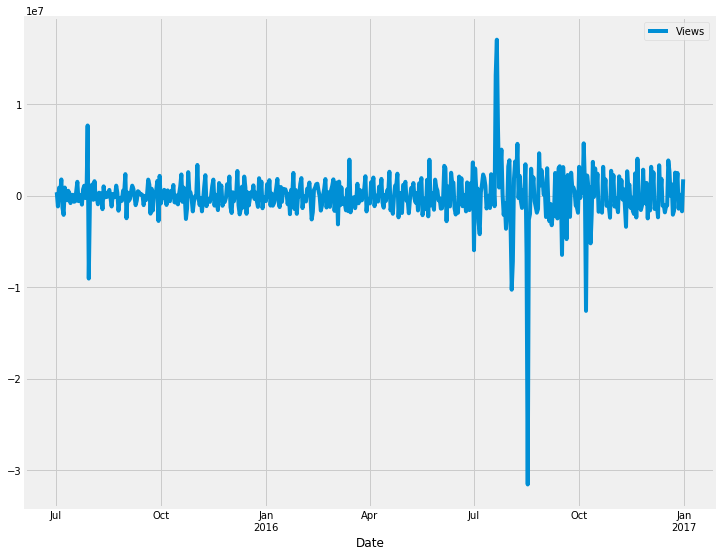

In [20]:
ax = stationary_df.plot()
plt.show()

In [21]:
test2 = adfuller(stationary_df['Views'])
print(test2)

(-6.6386055495935885, 5.481911439181468e-09, 14, 534, {'1%': -3.4426552678216003, '5%': -2.8669676577777548, '10%': -2.569660749624767}, 17054.780239373413)


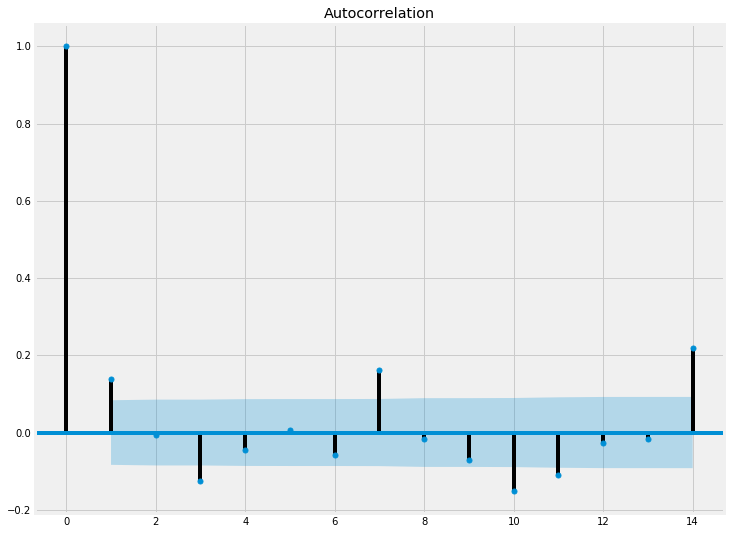

In [22]:
fig = tsaplots.plot_acf(stationary_df['Views'], lags=14)
plt.show()

## Modelling

In [23]:
train = top_page_filtered[:'2016-09']
test = top_page_filtered['2016-10':]

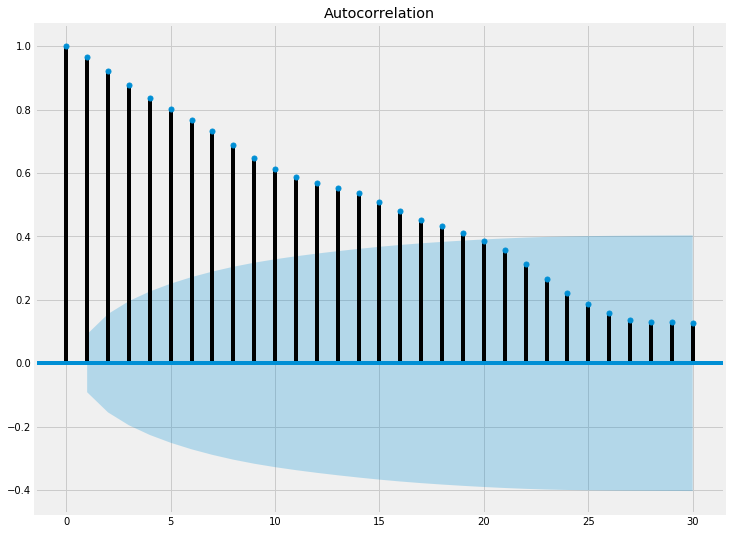

In [24]:
fig = tsaplots.plot_acf(train['Views'], lags=30)
plt.show()

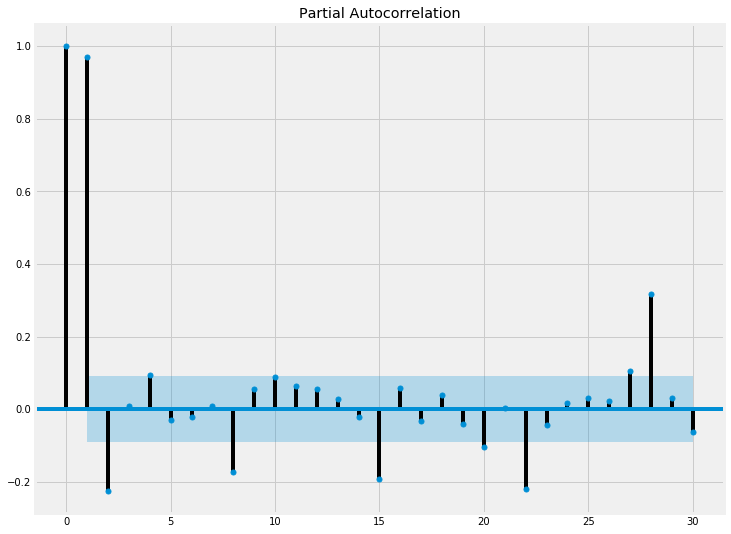

In [25]:
fig = tsaplots.plot_pacf(train['Views'], lags=30)
plt.show()

In [26]:
aic_bic_values = []
for p in range(7):
    for q in range(7):
        try:
            model = SARIMAX(train, order=(p,0,q))
            result = model.fit()
            aic_bic_values.append((p,q,result.aic,result.bic))
            print(p, q, result.aic, result.bic)
        except:
            print(p,q,None,None)


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


0 0 16859.00010687997 16863.126976064083
0 1 None None
0 2 None None
0 3 None None
0 4 None None
0 5 None None
0 6 None None
1 0 14807.702527176698 14815.956265544926


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarn

1 1 14792.572552218817 14804.95315977116
1 2 14793.233177982489 14809.740654718946


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 3 14790.291133578561 14810.925479499132
1 4 14792.313541257208 14817.074756361893


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 5 14794.411726878765 14823.299811167564


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1 6 14793.849593447057 14826.864546919971
2 0 14792.086337241422 14804.466944793765


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 1 14793.951283352564 14810.45876008902


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 2 14793.610585767623 14814.244931688194


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 3 14792.534281654174 14817.29549675886


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 4 14792.726998400238 14821.615082689037


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 5 14796.443901308448 14829.458854781362


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


2 6 14794.148078498223 14831.28990115525
3 0 14793.813483756048 14810.320960492505


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 1 14795.893017659622 14816.527363580193


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 2 14790.37794850681 14815.139163611495


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 3 14794.381758097432 14823.269842386231


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 4 14792.691315696786 14825.7062691697


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 5 14796.921524405036 14834.063347062063


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


3 6 14797.528824400993 14838.797516242135
4 0 14790.819647395858 14811.453993316429


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 1 14792.798856465235 14817.56007156992


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 2 14794.806427860283 14823.694512149083


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 3 14793.51138697442 14826.526340447333


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 4 14793.694217778459 14830.836040435486


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 5 14786.885487686723 14828.154179527864


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


4 6 14783.774700030768 14829.170261056024
5 0 14792.803266710784 14817.564481815469
5 1 14794.797878449062 14823.685962737862


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 2 14792.696862817644 14825.711816290557
5 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 4 14785.682102743413 14826.950794584554
5 5 14782.822766487483 14828.218327512739


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


5 6 14774.339992840534 14823.862423049904
6 0 14794.795705465396 14823.683789754195
6 1 14795.059344962307 14828.07429843522


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


6 2 14768.298740128015 14805.440562785043
6 3 None None


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


6 4 14782.893820676261 14828.289381701517
6 5 None None
6 6 14762.650358427061 14816.299657820546


C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [27]:
aic_bic_df = pd.DataFrame(aic_bic_values,columns=['p','q','aic','bic'])
print(aic_bic_df.sort_values('aic'))

    p  q           aic           bic
39  6  6  14762.650358  14816.299658
37  6  2  14768.298740  14805.440563
34  5  6  14774.339993  14823.862423
33  5  5  14782.822766  14828.218328
38  6  4  14782.893821  14828.289382
28  4  6  14783.774700  14829.170261
32  5  4  14785.682103  14826.950795
27  4  5  14786.885488  14828.154180
4   1  3  14790.291134  14810.925479
17  3  2  14790.377949  14815.139164
22  4  0  14790.819647  14811.453993
8   2  0  14792.086337  14804.466945
5   1  4  14792.313541  14817.074756
11  2  3  14792.534282  14817.295497
2   1  1  14792.572552  14804.953160
19  3  4  14792.691316  14825.706269
31  5  2  14792.696863  14825.711816
12  2  4  14792.726998  14821.615083
23  4  1  14792.798856  14817.560072
29  5  0  14792.803267  14817.564482
3   1  2  14793.233178  14809.740655
25  4  3  14793.511387  14826.526340
10  2  2  14793.610586  14814.244932
26  4  4  14793.694218  14830.836040
15  3  0  14793.813484  14810.320960
7   1  6  14793.849593  14826.864547
9

## Fitting ARMA model

In [28]:
model = SARIMAX(train,order=(6,0,2))
result = model.fit()

C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SUBIKSHAA\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [29]:
forecast = result.get_prediction(start=-30)
forecast_mean = forecast.predicted_mean

In [30]:
forecast_mean.head()

2016-09-01    3.198649e+07
2016-09-02    3.011212e+07
2016-09-03    3.055111e+07
2016-09-04    3.165442e+07
2016-09-05    3.254134e+07
Freq: D, dtype: float64

In [31]:
confidence_interval = forecast.conf_int()
confidence_interval.head()

,lower Views,upper Views
2016-09-01,2.715197e+07,3.682100e+07
2016-09-02,2.527761e+07,3.494662e+07
2016-09-03,2.571662e+07,3.538561e+07
2016-09-04,2.681992e+07,3.648891e+07
2016-09-05,2.770684e+07,3.737583e+07


## Predicting the number of views for the last 30 days using ARMA model

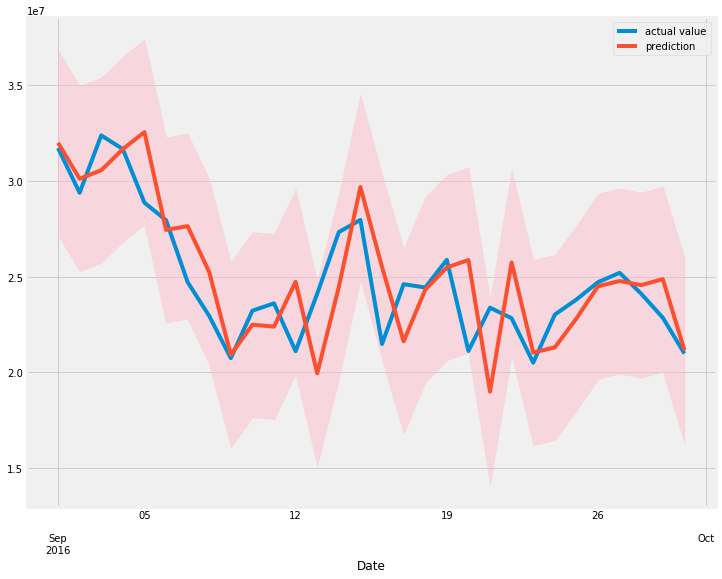

In [32]:
fig,ax=plt.subplots()
train[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
forecast_mean.plot(ax=ax,label='prediction')
plt.fill_between(confidence_interval.index, \
                confidence_interval['lower Views'], \
                confidence_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.legend()
plt.show()

## Forecasting

In [33]:
forecast_values = result.get_forecast(steps=test.shape[0])
forecast_values_mean = forecast_values.predicted_mean
conf_interval = forecast_values.conf_int()

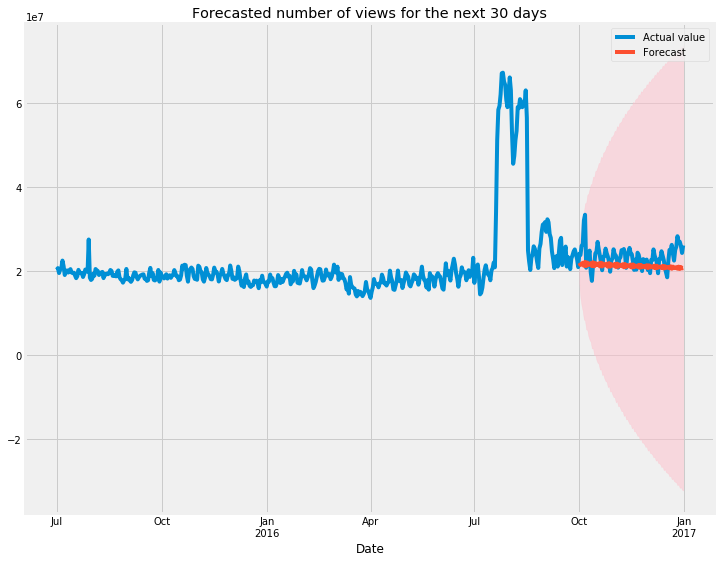

In [34]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
forecast_values_mean.plot(ax=ax,label='Forecast')
plt.fill_between(conf_interval.index, \
                conf_interval['lower Views'], \
                conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()

In [38]:
print('RMSE: '+str(np.sqrt(np.mean(np.square(forecast_values_mean.values - test.Views.values)))))

RMSE: 3289770.2459289175


## ARIMA model

In [ ]:
arima_aic_bic = []
for p in range(7):
    for q in range(7):
        try:
            arima_model = SARIMAX(top_page_filtered, order=(p,1,q))
            arima_result = arima_model.fit()
            arima_aic_bic.append((p,q,arima_result.aic,arima_result.bic))
        except:
            continue

arima_aic_bic_df = pd.DataFrame(arima_aic_bic,columns=['p','q','aic','bic'])
print(arima_aic_bic_df.sort_values('aic'))

In [ ]:
arima_model = SARIMAX(top_page_filtered,order=(6,1,5))
arima_result = arima_model.fit()
arima_forecast_mean = arima_result.get_prediction(steps=-30).predicted_mean

In [ ]:
fig,ax=plt.subplots()
top_page_filtered[-30:].rename(columns={'Views':'actual value'}).plot(ax=ax)
arima_forecast_mean.plot(ax=ax,label='prediction')
plt.legend()
plt.show()

In [ ]:
arima_forecast_values = arima_result.get_forecast(steps=30)
arima_forecast_mean = arima_forecast_values.predicted_mean
arima_conf_interval = arima_forecast_values.conf_int()

In [ ]:
fig,ax=plt.subplots()
top_page_filtered.rename(columns={'Views':'Actual value'}).plot(ax=ax)
arima_forecast_mean.plot(ax=ax,label='Forecast')
plt.fill_between(arima_conf_interval.index, \
                arima_conf_interval['lower Views'], \
                arima_conf_interval['upper Views'], \
                color='pink', alpha=0.5)
plt.title('Forecasted number of views for the next 30 days')
plt.legend()
plt.show()